# CNN_V1 optimization for multifruit datasets 
## (cross-fruit validation + single seed init)

## 1) Import libraries
In this first step we import all the main libraries

In [3]:
import os
import sys
from sys import stdout
import logging

import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from IPython.display import clear_output

import scipy.io as sio
from scipy.signal import savgol_filter
import tqdm
from itertools import permutations

from sklearn.preprocessing import StandardScaler 
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score, classification_report 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback,  ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical  
import tensorflow_addons as tfa

## Use liveslossplot for training visualization in real time
from livelossplot import PlotLossesKerasTF

import optuna
import GPUtil
from tabulate import tabulate
import psutil
import platform
import socket
from datetime import datetime

## If you have a weights and biases account, you can use it to track your experiments
# import wandb
# from wandb.keras import WandbCallback
# from optuna.integration.wandb import WeightsAndBiasesCallback

In [4]:
## Choose GPU:0 in case of multiple GPUs
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Print machine info
print('\n--------  Running @',socket.gethostname(),' using ', platform.platform(),'--------\n' ) 
# Get current date and time
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("Last run at =", dt_string)

### Print versions and hardware info
print('-------- SOFTWARE INFO --------')
print('Python ', sys.version)
print('Tensorflow ', tf.__version__)
print('Tensorflow add-ons ', tfa.__version__)
print('tqdm ', tqdm.__version__)
print('Numpy ', np.__version__)
print('Pandas', pd.__version__)
print('Optuna ', optuna.__version__)
# print('livelossplot ', livelossplot.__version__)

## print hardware info
print('\n-------- HARDWARE INFO --------')
# CPU
print('CPU:', platform.processor())
print("\tPhysical cores:", psutil.cpu_count(logical=False))
print("\tTotal cores:", psutil.cpu_count(logical=True))
cpufreq = psutil.cpu_freq()
print(f"\tMax Frequency: {cpufreq.max:.2f}Mhz")
# RAM
print(f'RAM: {int(np.round(psutil.virtual_memory().total / (1024. **3)))} Gb')
# GPU
print('GPU available: ', tf.config.list_physical_devices('GPU'))
print("="*40, "GPU Details", "="*40)
gpus = GPUtil.getGPUs()
list_gpus = []
for gpu in gpus:
    # get the GPU id
    gpu_id = gpu.id
    # name of GPU
    gpu_name = gpu.name
    # get % percentage of GPU usage of that GPU
    gpu_load = f"{gpu.load*100}%"
    # get free memory in MB format
    gpu_free_memory = f"{gpu.memoryFree}MB"
    # get used memory
    gpu_used_memory = f"{gpu.memoryUsed}MB"
    # get total memory
    gpu_total_memory = f"{gpu.memoryTotal}MB"
    # get GPU temperature in Celsius
    gpu_temperature = f"{gpu.temperature} °C"
    gpu_uuid = gpu.uuid
    list_gpus.append((
        gpu_id, gpu_name, gpu_load, gpu_free_memory, gpu_used_memory,
        gpu_total_memory, gpu_temperature, gpu_uuid
    ))

print(tabulate(list_gpus, headers=("id", "name", "load", "free memory", "used memory", "total memory",
                                   "temperature", "uuid")))

print('\nIs CUDA accessible by the GPU? ', tf.test.is_built_with_cuda())


--------  Running @ Athena  using  Windows-10-10.0.23580-SP0 --------

Last run at = 02/11/2023 14:32:36
-------- SOFTWARE INFO --------
Python  3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
Tensorflow  2.10.0
Tensorflow add-ons  0.20.0
tqdm  4.64.1
Numpy  1.24.2
Pandas 2.0.3
Optuna  3.2.0

-------- HARDWARE INFO --------
CPU: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
	Physical cores: 24
	Total cores: 32
	Max Frequency: 3000.00Mhz
RAM: 64 Gb
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
======================================== GPU Details ========================================
  id  name                        load    free memory    used memory    total memory    temperature    uuid
----  --------------------------  ------  -------------  -------------  --------------  -------------  ----------------------------------------
 

## 2) Help functions
In this section we implement a series of help functions that will be used during the optimization procedure. Run every cell once to ensure that all help functions are loaded.

In [5]:
## Define random seeds ir order to maintain reproducible results through multiple testing phases
def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
reproducible_comp()

Axiliary function to compute error metrics and make prediction plots

In [6]:
## Function to compute metrics and make prediction plots
def plot_prediction(X_calib, Y_calib, X_valid, Y_valid, X_test, Y_test, Y_calib_pred, Y_valid_pred, Y_test_pred, savefig=False, figname=None):
    
    ## Compute train error scores 
    score_p0 = r2_score(Y_calib, Y_calib_pred)
    mse_p0 = mean_squared_error(Y_calib, Y_calib_pred)
    rmse_p0 = np.sqrt(mse_p0)
    
    ## Compute valid error scores
    score_p1 = r2_score(Y_valid, Y_valid_pred)
    mse_p1 = mean_squared_error(Y_valid, Y_valid_pred)
    rmse_p1 = np.sqrt(mse_p1)
        
    ## Compute test error scores 
    score_p2 = r2_score(Y_test, Y_test_pred)
    mse_p2 = mean_squared_error(Y_test, Y_test_pred)
    rmse_p2 = np.sqrt(mse_p2)

  
    print('ERROR METRICS: \t TRAIN \t\t VALID \t\t TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f \t\t %5.3f \t\t %5.3f'  % (score_p0, score_p1, score_p2 ))
    print('RMSE: \t\t %5.3f \t\t %5.3f \t\t %5.3f' % (rmse_p0, rmse_p1,  rmse_p2))
    
 
    ## Plot regression for PLS predicted data
    rangey = max(Y_test) - min(Y_test)
    rangex = max(Y_test_pred) - min(Y_test_pred)

    fig=plt.figure(figsize=(6,6))
    z = np.polyfit(np.ravel(Y_test), np.ravel(Y_test_pred), 1)
    ax = plt.subplot(aspect=1)
    ax.scatter(Y_test,Y_test_pred,c='k',marker='o',s=20, alpha=0.6)
    ax.plot(Y_test, z[1]+z[0]*Y_test, c='blue', linewidth=2,label='linear fit')
    ax.plot(Y_test, Y_test, 'k--', linewidth=1.5, label='y=x')
    plt.ylabel('Predicted DM')
    plt.xlabel('Measured DM')
    plt.title('Prediction from CNN')
    plt.legend(loc=4)

    
    # Print the scores on the plot
    plt.text(min(Y_test_pred)+0.02*rangex, max(Y_test)-0.1*rangey, 'R$^{2}=$ %5.3f'  % score_p2)
    plt.text(min(Y_test_pred)+0.02*rangex, max(Y_test)-0.15*rangey, 'RMSE: %5.3f' % rmse_p2)
    if savefig==True:
        plt.savefig(figname, dpi=96)
        print('Figure saved')
    else:    
        plt.show() 
    return 

Set parameters for graphics formating

In [7]:
## Graphics settings
## Setting the font sizes for comming figures
# plt.style.use("default")
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

## uncomment for Latex graphics formating
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": ["Times"]})

# plt.rc('text', usetex=True)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 3) Data wrangling

### 3.1) Loading the tuttifruti dataset

Read the data (matlab format) using the scipy.io module 

In [8]:
data = sio.loadmat('../data/multifruit_DL.mat')
print(data.keys())

## wavelenght for plots
w = np.ravel(data['wavelength'])

dict_keys(['__header__', '__version__', '__globals__', 'apple_sp', 'avocado_sp', 'dm_apple', 'dm_avocado', 'dm_kiwi', 'dm_mango', 'dm_pear', 'kiwi_sp', 'mango_sp', 'pear_sp', 'wavelength'])


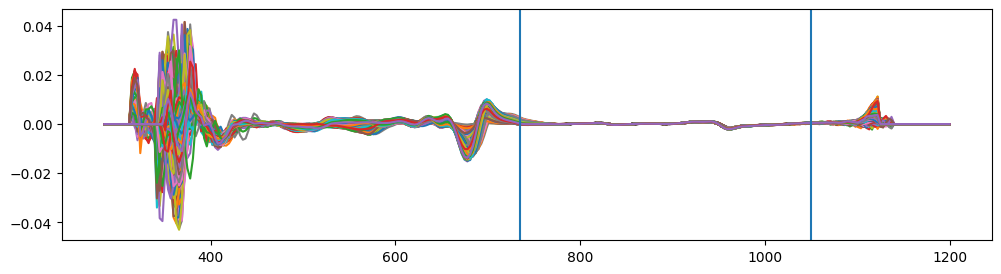

(725, 105)


In [9]:
## initial and final spectral features
wi = 150
wf = 255
plt.figure(figsize=(12,3))
plt.plot(w,data['mango_sp'].T)
plt.axvline(w[wi])
plt.axvline(w[wf])
plt.show()

print(np.shape(data['mango_sp'][:,wi:wf]))

We further split the training set into "calibration" and "tuning" subsets. This will be useful for the hyperparameter optimization of the models ahead. 

In [10]:
## initial and final spectral features
wi = 150
wf = 255

## train / test split of datasets
x_apple_train, x_apple_test, y_apple_train, y_apple_test = train_test_split(data['apple_sp'][:,wi:wf], data['dm_apple'], test_size=0.2, random_state=42)
x_avocado_train, x_avocado_test, y_avocado_train, y_avocado_test = train_test_split(data['avocado_sp'][:,wi:wf], data['dm_avocado'], test_size=0.2, random_state=42)
x_kiwi_train, x_kiwi_test, y_kiwi_train, y_kiwi_test = train_test_split(data['kiwi_sp'][:,wi:wf], data['dm_kiwi'], test_size=0.2, random_state=42)
x_mango_train, x_mango_test, y_mango_train, y_mango_test = train_test_split(data['mango_sp'][:,wi:wf], data['dm_mango'], test_size=0.2, random_state=42)
x_pear_train, x_pear_test, y_pear_train, y_pear_test = train_test_split(data['pear_sp'][:,wi:wf], data['dm_pear'], test_size=0.2, random_state=42)

print('Datasets dimensions:')
print('Apple: train {}, test {} '.format([x_apple_train.shape, y_apple_train.shape],[x_apple_test.shape, y_apple_test.shape]))
print('Avocado: train {}, test {} '.format([x_avocado_train.shape, y_avocado_train.shape],[x_avocado_test.shape, y_avocado_test.shape]))
print('Kiwi: train {}, test {} '.format([x_kiwi_train.shape, y_kiwi_train.shape],[x_kiwi_test.shape, y_kiwi_test.shape]))
print('Mango: train {}, test {} '.format([x_mango_train.shape, y_mango_train.shape],[x_mango_test.shape, y_mango_test.shape]))
print('Pear: train {}, test {} '.format([x_pear_train.shape, y_pear_train.shape],[x_pear_test.shape, y_pear_test.shape]))

Datasets dimensions:
Apple: train [(1124, 105), (1124, 1)], test [(281, 105), (281, 1)] 
Avocado: train [(464, 105), (464, 1)], test [(116, 105), (116, 1)] 
Kiwi: train [(438, 105), (438, 1)], test [(110, 105), (110, 1)] 
Mango: train [(580, 105), (580, 1)], test [(145, 105), (145, 1)] 
Pear: train [(255, 105), (255, 1)], test [(64, 105), (64, 1)] 


In [11]:
## Create lists with multi fruit data for train and test

## Train data
x_train_list = [x_apple_train.astype(np.float32), x_kiwi_train.astype(np.float32),  x_mango_train.astype(np.float32), \
                x_pear_train.astype(np.float32), x_avocado_train.astype(np.float32)]

y_train_list = [y_apple_train.astype(np.float32), y_kiwi_train.astype(np.float32), y_mango_train.astype(np.float32),
                y_pear_train.astype(np.float32), y_avocado_train.astype(np.float32)]

## Test data
x_test_list = [x_apple_test.astype(np.float32), x_kiwi_test.astype(np.float32),  x_mango_test.astype(np.float32), \
               x_pear_test.astype(np.float32), x_avocado_test.astype(np.float32)]
y_test_list = [y_apple_test.astype(np.float32), y_kiwi_test.astype(np.float32), y_mango_test.astype(np.float32),\
               y_pear_test.astype(np.float32), y_avocado_test.astype(np.float32)]

## Create a list with the names of the fruits
fruits = ['Apple', 'Kiwi', 'Mango', 'Pear', 'Avocado']


### 3.2) Data pre-processing and train test split

In [12]:
## Since the test set is unknown (we are not suppose to have access to it during the
## optimization of the model) the scalling process should take this into account. We
## have to define a scaler based only on the train data, and apply it to the test data.

def standardize_column(X_train, X_test):
    ## We train the scaler on the full train set and apply it to the other datasets
    scaler = StandardScaler().fit(X_train)
    ## for columns we fit the scaler to the train set and apply it to the test set
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return [X_train_scaled, X_test_scaled]

In [13]:
## Standardize the spectra (Leaving out avocado data)
x_train_scaled_col, x_test_scaled_col = standardize_column(np.concatenate(x_train_list[:-1]), np.concatenate(x_test_list[:-1]))

y_train = np.concatenate(y_train_list[:-1])
y_test = np.concatenate(y_test_list[:-1])

## 4) Regression CNN Optimization (fixed init seed)

In [14]:
## Make computations reproducible
reproducible_comp()

## Define the model
def create_model(num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train_scaled_col)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_NUMBER = 1
    K_WIDTH = filter_size
    K_STRIDE = 1
    OUTPUT_DIMS = 1
    
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## For the sake of simplicity we do the weights initialization for multiple layers here
    K_INIT = tf.keras.initializers.he_normal(seed=123)
    
    ## Architecture of the main model
    ## This way of implementing the model is analogous to the way we previously did although it is done
    ## in an alternative way that allows a bit more coding freedom. 
    model_cnn = keras.Sequential(name='MODEL_CNN_V1')
    model_cnn.add(keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,), name='INPUT'))
    model_cnn.add(keras.layers.Conv1D(filters=K_NUMBER, \
                                      kernel_size=K_WIDTH, \
                                      strides=K_STRIDE, \
                                      padding='same', \
                                      kernel_initializer=K_INIT,\
                                      kernel_regularizer=K_REG,\
                                      activation='elu',\
                                      input_shape=(CONV1D_DIMS,1), name='CONVOLUTIONAL'))
    
    model_cnn.add(keras.layers.Flatten(name='FLATTEN'))
    
    ## For the FC layer block, we implement a loop that adds dense layers with a certain number of units
    ## followed by a dropout layer (with a certain dropout rate)
    ## The number of layers, units, dropout rate, etc. will be optmized. Note that a dropout rate = 0 is
    ## the same as excluding that dropout layer... 
    for i in range(0, num_FC_layers):
        model_cnn.add(keras.layers.Dense(num_FC_units[i], \
                                         kernel_initializer=K_INIT, \
                                         kernel_regularizer=K_REG,\
                                         activation='elu', 
                                         name='DENSE_'+str(i)))
        if i != num_FC_layers - 1:  # Only add dropout if it's not the last iteration
            model_cnn.add(keras.layers.Dropout(DROPOUT[i], name='DROPOUT_'+str(i)))  

    ## Final layer for multi-label classification
    model_cnn.add(keras.layers.Dense(OUTPUT_DIMS, kernel_initializer=K_INIT, \
                                        activation='linear', name='OUTPUT'))
                             
    
    return model_cnn

### 4.1) Bayesian Optimization (BO) of the hyperparameters

First we create a cross-validation strategy that switches fruit groups as part of the validation process.

In [ ]:
def standardize_column2(X_train, X_cal, X_val):
    ## We train the scaler on the full train set and apply it to the other datasets
    scaler = StandardScaler().fit(X_train)
    ## for columns we fit the scaler to the train set and apply it to the test set
    X_cal_scaled = scaler.transform(X_cal)
    X_val_scaled = scaler.transform(X_val)
    return [X_cal_scaled, X_val_scaled]


## Set the path where the computed models are saved
path='regression_models_v1/'

## initialize an empty list for storing additional metrics
metricas = []

## Callbacks to use during training
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=52, mode='auto', restore_best_weights=True)
## Note that the min_lr in rdlr is the one found in the LRFinder test

rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)

## This callback draws small progress bar in the screen for each training session. Its useful to check the progress of the task
progressbar = tfa.callbacks.TQDMProgressBar(show_epoch_progress = False)

## Add support for wandb logging
# wandb_kwargs = {"project": "multifruit_CNN_embedding", "name": "study_v1_"+dt_string.replace(':','_').replace('/','_').replace(' ','_')}
# wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)

## Define the objective function to monitor during optimization, set the hyperperameters ranges, etc.
def objective(trial):

    print('\n\n-------------- TRIAL NUMBER: ',trial.number,'------------------')
    
    ## Clear clutter from previous session   
    keras.backend.clear_session()
    
    ## Redifine the train list data (without avocado data)
    x_train_list = [x_apple_train.astype(np.float32), x_kiwi_train.astype(np.float32),  x_mango_train.astype(np.float32), \
                    x_pear_train.astype(np.float32)]
    y_train_list = [y_apple_train.astype(np.float32), y_kiwi_train.astype(np.float32), y_mango_train.astype(np.float32),
                    y_pear_train.astype(np.float32)]

    ## Create a list with the names of the fruits
    fruits = ['Apple', 'Kiwi', 'Mango', 'Pear']
    
    ## In the follow steps we define the search space for each of the hyperparameters. This is done by using
    ## distributions/intervals of integers or floats from a min, to a max with a certain step.
        
    ## Number of FC layers
    NUM_FC_LAYERS = trial.suggest_int("num_FC_layers",1,3, step=1)
    ## Number of units per layer
    NUM_FC_UNITS = [int(trial.suggest_int("num_FC_UNITS_"+str(i), 8, 128, step=4)) for i in range(0,NUM_FC_LAYERS)]
    ## Filter size  (K_WIDTH)
    FILTER_SIZE = int(trial.suggest_int("filter_size", 1, 45, step=2)) 
    ## Dropout rate (DROPOUT)
    DROPOUT_RATE = [trial.suggest_float("DROPOUT_"+str(i), 0., 0.6, step=0.005) for i in range(0,NUM_FC_LAYERS-1)]
    ## L2 regularization
    REG_BETA = trial.suggest_float("reg_beta", 0, 0.1, step=0.0005)
    ## Add batch size to the hyperparameters to be optimized. This hyperparameter is not used directly by the model()
    ## but is used in the training phase.
    BATCH_SIZE = int(trial.suggest_int("batch_size", 32, 256, step=16))
    ## Initial LR for Adam optimizer corresponding to the LRmax chosen in the LRFinder test
    LR=0.03

    ## Instatiate the model for a new set of hyperparameters
    model = create_model(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT_RATE, REG_BETA)
    print('\n\ncreate_model(',NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT_RATE, REG_BETA,')')
    model.summary()
    print('\n')
       
    ## Compile the model, use Adam() as optimizer, and mean squared error (mse) as loss function
    ## Note: the learning_rate in Adam() is set to the max LR found in the LRFinder test
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"])
        
       
    ## Empty lists to store the training and validation metrics
    scores_cal_list = []
    scores_val_list = []

    x_train = np.concatenate(x_train_list)
    
    for i in np.arange(0, len(x_train_list)):
        
            ## Split the train data into calibration and validation sets
            x_cal_i = np.concatenate(x_train_list[:3])  # the first 3 fruit
            x_val_i = x_train_list[-1] # the last fruit
            
            y_cal_i = np.concatenate(y_train_list[:3])
            y_val_i = y_train_list[-1]
            
            cal_set_name = fruits[:3]
            val_set_name = fruits[-1]
            
            print('\n Trial(Run) = ',trial.number,'(',i+1,') -----------\n Training on cal set: ', cal_set_name, ' and validating on val set: ', val_set_name)

            ## Standardize the calibration and validation sets
            x_cal_i_scaled_col, x_val_i_scaled_col = standardize_column2(x_train, x_cal_i, x_val_i)
            
            ## Shuflle the calibration data
            x_cal_i_scaled_col, y_cal_i = shuffle(x_cal_i_scaled_col, y_cal_i, random_state=42)

            ## Reinitialize the model weights
            model = create_model(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT_RATE, REG_BETA)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"])
            ## define the model/study name. In this case we will save a model with the same name of its trial
            MODEL_NAME='study_v1_trial='+str(trial.number)+'('+str(i)+').h5'
            ## Callbacks
            checkpointer = keras.callbacks.ModelCheckpoint(filepath=path+MODEL_NAME, verbose = 0, save_best_only = True)

            ## Train the model on cal data and validate it on val data
            model.fit(x_cal_i_scaled_col, y_cal_i, batch_size = BATCH_SIZE, epochs = 500, \
                      validation_data = (x_val_i_scaled_col, y_val_i), \
                      callbacks=[rdlr, early_stop, checkpointer, progressbar], \
                      verbose=0)
            
            ## Load the best model weights
            model.load_weights(path+MODEL_NAME)
    
            ## Compute auxiliary metrics
            scores_cal = model.evaluate(x_cal_i_scaled_col, y_cal_i, verbose=0)
            print('Calibration using {} RMSE = {}'.format(cal_set_name, np.sqrt(scores_cal[1])))
            scores_cal_list.append(np.sqrt(scores_cal[1]))
            
            scores_val = model.evaluate(x_val_i_scaled_col, y_val_i, verbose=0) 
            print('Validation using {} RMSE = {}'.format(val_set_name, np.sqrt(scores_val[1])))
            scores_val_list.append(np.sqrt(scores_val[1]))

            ## Rotate the train data to use a different set of fruits as calibration and validation sets
            ## we use slicing to create a new list that contains all elements of the original list except the first 
            ## one (my_list[1:]) and then add the first element of the original list to the end of the new list (+ my_list[:1]).
            x_train_list = x_train_list[1:] + x_train_list[:1]
            y_train_list = y_train_list[1:] + y_train_list[:1]
            fruits = np.roll(fruits, 1)

            ## Clear clutter from previous session
            keras.backend.clear_session()
    ### END FOR LOOP

    ## Compute the mean of the metrics over the 4 trials
    scores_cal_mean = np.mean(scores_cal_list)
    scores_val_mean = np.mean(scores_val_list)
    scores_cal_std = np.std(scores_cal_list)
    scores_val_std = np.std(scores_val_list)
    
    print('\n\nMEAN OVER CROSS-FRUIT VALIDATION ----------------------------------')
    print('Multifruit calibration RMSE = {}+-{}'.format(scores_cal_mean, scores_cal_std))
    print('Multifruit validation RMSE = {}+-{}\n\n'.format(scores_val_mean, scores_val_std))
    
    ## Append each trial's hyperparameters and scores into a list for later analysis 
    metricas.append([MODEL_NAME, NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT_RATE, 
                     REG_BETA, BATCH_SIZE, scores_cal_mean, scores_val_mean])
    
    # wandb.log(data={"Trial": trial.number})
    # wandb.log(data={"Mean RMSE cal": scores_cal_mean})
    # wandb.log(data={"Mean RMSE val": scores_val_mean})
    # config = dict(trial.params)
    # wandb.log(data=config)
    
    ## The metric we want to minimize. In this case we are chosing weighted sum between tuning and cal metrics
    return scores_val_mean

In [ ]:
## Enable Optuna logger (for tracking purposes) 
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

## Unique identifier of the study
study_name = "study_v1"

## Name of the SQL data base where optuna saves the trials, values, etc... 
## The optimization and logs the results into a database .db file that can be monitored in real time with the optuna-dashboard
storage_name = "sqlite:///{}.db".format(study_name)

## Create a study that will, in this case minimize the objective function previously defined
## We use TPE with a cte seed (for reproducibility), consider_endpoints = True (to consider the min and max values of the search space).
study_v1 = optuna.create_study(study_name=study_name, \
                            storage=storage_name,  \
                            direction='minimize',  \
                            sampler = optuna.samplers.TPESampler(seed = 12345,\
                                                                 consider_endpoints = True,\
                                                                 multivariate = True,\
                                                                 n_startup_trials = 100,\
                                                                 warn_independent_sampling=False),\
                            load_if_exists=True)


## Start optimization with a budget of n_trials
study_v1.optimize(objective, n_trials = 1000) # Use callbacks=[wandbc] if you want to log the results to wandb

In [15]:
metricas_df=pd.DataFrame(metricas, columns=['MODEL_NAME', 'NUM_FC_LAYERS', 'NUM_FC_UNITS', 'FILTER_SIZE', 'DROPOUT_RATE', 'REG_BETA',
                                            'BATCH_SIZE', 'RMSE_cal_mean', 'RMSE_val_mean'])

metricas_df.to_csv('metricas_v1.csv')

In [15]:
study_v1 = optuna.load_study(study_name="study_v1", storage="sqlite:///study_v1.db")
print('Best trial:',study_v1.best_trial.number)
print('Best trial value:',study_v1.best_trial.value)
print('Best trial hyperparameters:',study_v1.best_trial.params)

Best trial: 408
Best trial value: 1.109058731830332
Best trial hyperparameters: {'DROPOUT_0': 0.54, 'batch_size': 224, 'filter_size': 3, 'num_FC_UNITS_0': 108, 'num_FC_UNITS_1': 44, 'num_FC_layers': 2, 'reg_beta': 0.0735}
